# Inference Attack with AutoML and Cifar10 -- Trial \#3
ISU CEADS Lab under Dr. Leslie Kerby <br>
Samantha Ross <br><br>

This is a notebook detailing an inference attack (or "model stealing") against an EfficientNetB0 architecture using AutoML (AutoKeras) and the Cifar10 data set. Note that AutoKeras is very memory intensive, and so all models should be saved to ensure they can be loaded back in on a notebook RAM crash.

## TensorFlow Versioning
TensorFlow has now updated to v2.12. This notebook was originally created using TensorFlow v2.11 and Protobuf v3.19. Downgrading to TensorFlow v2.9 was necessary to avoid an internal TensorFlow error when serializing/saving EfficientNetB0 models. <br><br>

This is no longer necessary. To run this notebook with TensorFlow v2.12, just use "EfficientNetV2B0" instead of "EfficientNetB0." <br><br>

In [ ]:
# # Disconnect runtime and run this as FIRST thing before continuing (ignore above cells)
# !pip install tensorflow==2.9.0
# import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 80.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting unin

In [ ]:
# print(tf.__version__) # SUCCESS!

2.9.0


# Imports

In [ ]:
# Installs and Imports
!pip install autokeras

import autokeras as ak
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 69.2 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load Cifar10
The data is loaded in via a TensorFlow Dataset Pipeline (TFDS) such that there will be 36k in training, 4k in validation, and 20k in training. Since Cifar10's default is 50k in training and 10k in testing, an additional variable is added to the pipeline to hold 10k. This is concatenated with the test set (also 10k) to create a test set of 20k.

In [ ]:
(ds_train, ds_valid, ds_test1, ds_test2)= tfds.load(
    'cifar10',
    split = ['train[:36000]', 'train[36000:40000]', 'train[40000:]','test'],
    shuffle_files = True,
    as_supervised = True,
)

In [ ]:
print(len(list(ds_train)))
print(len(list(ds_valid)))
print(len(list(ds_test1)))
print(len(list(ds_test2)))

36000
4000
10000
10000


In [ ]:
ds_test = ds_test1.concatenate(ds_test2)

In [ ]:
print(len(list(ds_test)))

20000


## Resizing/DataAug via Pipelines
Using pipelines, the data is resized to 80x80 images and the training data is augmented.

In [ ]:
# Build transformation pipeline for TFDS Datasets

def preprocess(image, label): 
  image = tf.image.resize(image, [80, 80]) # 80x80 pixels
  return (image, label)

def data_aug(image, label):
  image = tf.image.random_flip_left_right(image)
  return (image, label)

# apply -- but data augmentation to training set only
ds_train = ds_train.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid = ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test = ds_test.map(preprocess).batch(32).prefetch(1)

In [ ]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 80, 80, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Victim Model
The victim model architecture utilizes EfficientNetB0, 2D global averaging pooling, and dropout (0.02).

In [ ]:
base_model = keras.applications.EfficientNetB0(weights="imagenet", 
                                              include_top=False,
                                             input_shape=(80,80,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.02)(global_avg)
output = keras.layers.Dense(10, activation="softmax")(dropout)
victim_model = keras.models.Model(inputs=base_model.input, outputs=output)

16705208/16705208 [==============================] - 0s 0us/step


## Training

In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

# Compile victim model
victim_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

# Train frozen layers
history1 = victim_model.fit(ds_train, batch_size=32,
                    epochs=30, validation_data=ds_valid, 
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/30
1125/1125 [==============================] - 477s 416ms/step - loss: 0.7153 - accuracy: 0.7624 - val_loss: 0.5691 - val_accuracy: 0.8025
Epoch 2/30
1125/1125 [==============================] - 420s 374ms/step - loss: 0.5435 - accuracy: 0.8133 - val_loss: 0.5292 - val_accuracy: 0.8133
Epoch 3/30
1125/1125 [==============================] - 418s 372ms/step - loss: 0.5034 - accuracy: 0.8276 - val_loss: 0.5148 - val_accuracy: 0.8190
Epoch 4/30
1125/1125 [==============================] - 415s 369ms/step - loss: 0.4791 - accuracy: 0.8359 - val_loss: 0.5049 - val_accuracy: 0.8270
Epoch 5/30
1125/1125 [==============================] - 451s 401ms/step - loss: 0.4659 - accuracy: 0.8399 - val_loss: 0.5027 - val_accuracy: 0.8292
Epoch 6/30
1125/1125 [==============================] - 456s 405ms/step - loss: 0.4531 - accuracy: 0.8447 - val_loss: 0.4991 - val_accuracy: 0.8295
Epoch 7/30
1125/1125 [==============================] - 410s 365ms/step - loss: 0.4419 - accuracy: 0.8460 - val_

In [ ]:
victim_model.evaluate(ds_test)

625/625 [==============================] - 210s 336ms/step - loss: 0.4946 - accuracy: 0.8321


[0.4945610463619232, 0.832099974155426]

<AxesSubplot:>

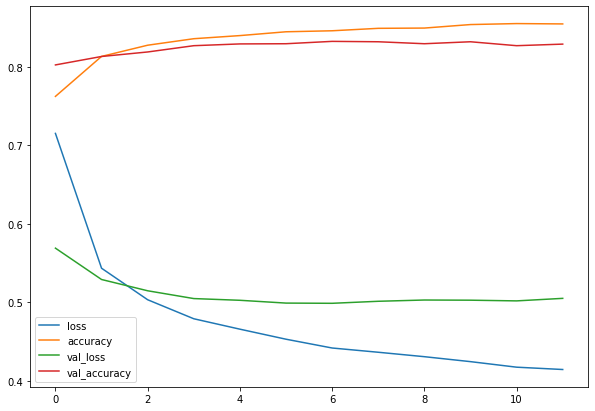

In [ ]:
# Attack model training acc/loss graph
pd.DataFrame(history1.history).plot(figsize=(10,7)) 
# **NEEDS X_test and y_test from ds_test (execute only after they've been extracted!!)

In [ ]:
# Unfreeze layers and train
%%time
for layer in base_model.layers:
    layer.trainable = True

# Recompile victim model (resets model)
victim_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4),
                metrics=["accuracy"])

# Train unfrozen layers
history2 = victim_model.fit(ds_train, batch_size=32,
                    epochs=60, validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/60
1125/1125 [==============================] - 1881s 2s/step - loss: 0.7432 - accuracy: 0.7751 - val_loss: 0.4237 - val_accuracy: 0.8648
Epoch 2/60
1125/1125 [==============================] - 1858s 2s/step - loss: 0.2499 - accuracy: 0.9153 - val_loss: 0.3622 - val_accuracy: 0.8832
Epoch 3/60
1125/1125 [==============================] - 1861s 2s/step - loss: 0.1081 - accuracy: 0.9655 - val_loss: 0.3592 - val_accuracy: 0.8945
Epoch 4/60
1125/1125 [==============================] - 1939s 2s/step - loss: 0.0578 - accuracy: 0.9822 - val_loss: 0.3602 - val_accuracy: 0.8985
Epoch 5/60
1125/1125 [==============================] - 1856s 2s/step - loss: 0.0437 - accuracy: 0.9863 - val_loss: 0.3857 - val_accuracy: 0.9018
Epoch 6/60
1125/1125 [==============================] - 1914s 2s/step - loss: 0.0383 - accuracy: 0.9878 - val_loss: 0.3911 - val_accuracy: 0.9070
Epoch 7/60
1125/1125 [==============================] - 1929s 2s/step - loss: 0.0329 - accuracy: 0.9893 - val_loss: 0.3878 -

In [ ]:
victim_model.evaluate(ds_test)

625/625 [==============================] - 215s 344ms/step - loss: 0.4053 - accuracy: 0.9057


[0.4052656888961792, 0.9057499766349792]

<AxesSubplot:>

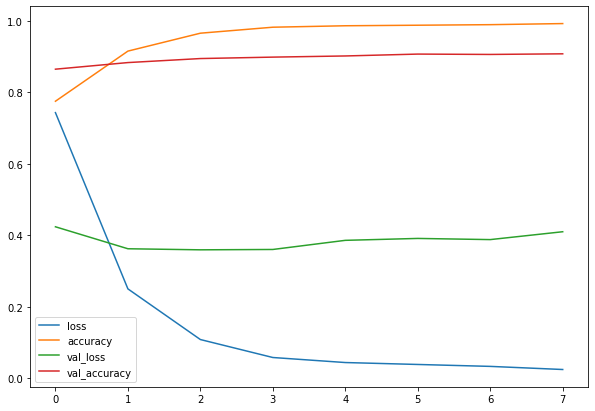

In [ ]:
# Attack model training acc/loss graph
pd.DataFrame(history2.history).plot(figsize=(10,7)) 
# **NEEDS X_test and y_test from ds_test (execute only after they've been extracted!!)

## Pred, CM
Victim model's predictions and confusion matrix on its test images

In [ ]:
# Victim model predictions
y_pred = np.argmax(victim_model.predict(ds_test), axis=-1)
print(y_pred[:10])

625/625 [==============================] - 18s 14ms/step
[4 0 4 7 6 6 6 0 2 8]


In [ ]:
# get X_test and y_test from ds_test

# get y_test from ds_test
y_test = np.concatenate([y for x, y in ds_test], axis=0)

# get X_test from ds_test
train_ds = ds_test.unbatch()
X_test = np.asarray(list(train_ds.map(lambda x, y: x)))
print(X_test.shape)

# GO BACK and execute training graph cells*

(20000, 80, 80, 3)


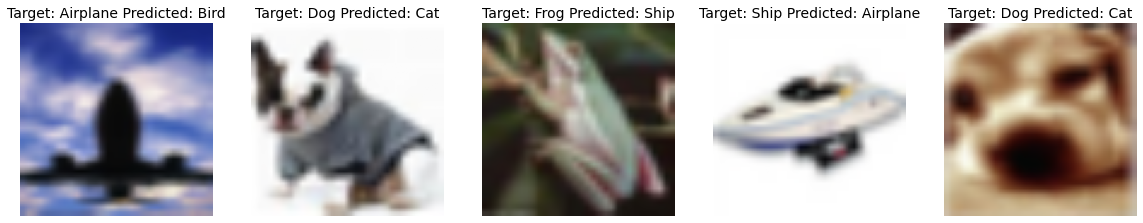

In [ ]:
# Display misclassified images for this experimental model
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 
           'Frog', 'Horse', 'Ship', 'Truck']

misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test, y_pred):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(20,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  plt.imshow(X_test[misclassifiedIndexes[index]].reshape(80,80,3)/255, cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {classes[y_test[misclassifiedIndexes[index]]]} Predicted: {classes[y_pred[misclassifiedIndexes[index]]]}', fontsize=14)

plt.show()

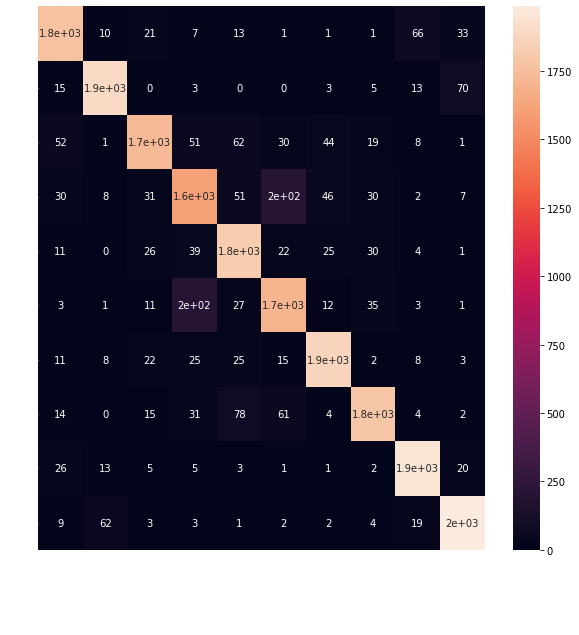

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True class', color='white')
plt.xlabel('Predicted class', color='white')
plt.tick_params(color='white',labelcolor='white')
plt.show()

# Stealing the Model
The goal is to create a functionally equivalent, reverse-engineered model with AutoML. We will attempt this by doing a gray-box attack, assuming we have access to some subset of the data (in this case, X_test) and the target model's predictions on that data. We will be training AutoKeras on a train/test split of that data subset and the target's predictions.

In [ ]:
# split victim test data from X_test and y_pred
# Use X_test and y_pred from victim model
X_train_tr2, X_test2, y_train_tr2, y_test2 = train_test_split(X_test, y_pred,
                                                                test_size=1/10)
print(X_test.shape)
print(y_test2.shape)

print()
print(X_train_tr2.shape)
print(X_test2.shape)
print(y_train_tr2.shape)
print(y_test2.shape)

(20000, 80, 80, 3)
(2000,)

(18000, 80, 80, 3)
(2000, 80, 80, 3)
(18000,)
(2000,)


## Training

In [ ]:
# initialize AK image classifier that will try 2 models (for time)
auto_model = ak.ImageClassifier(max_trials=3, loss = 'sparse_categorical_crossentropy') # specifying loss

In [ ]:
# Search for the best model
am_history2 = auto_model.fit(X_train_tr2, y_train_tr2, 30,
                 callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Trial 3 Complete [02h 01m 08s]
val_loss: 0.37980324029922485

Best val_loss So Far: 0.37980324029922485
Total elapsed time: 03h 44m 34s


Epoch 1/30


Not enough memory, reduce batch size to 16.
Epoch 1/30
1125/1125 [==============================] - 1055s 938ms/step - loss: 0.9318 - accuracy: 0.7195
Epoch 2/30
1125/1125 [==============================] - 1054s 937ms/step - loss: 0.3991 - accuracy: 0.8770
Epoch 3/30
1125/1125 [==============================] - 1059s 941ms/step - loss: 0.2681 - accuracy: 0.9183
Epoch 4/30
1125/1125 [==============================] - 1055s 938ms/step - loss: 0.1678 - accuracy: 0.9511
Epoch 5/30
1125/1125 [==============================] - 1056s 938ms/step - loss: 0.0977 - accuracy: 0.9733
Epoch 6/30
1125/1125 [==============================] - 1054s 937ms/step - loss: 0.0608 - accuracy: 0.9833
Epoch 7/30
1125/1125 [==============================] - 1054s 937ms/step - loss: 0.0378 - accuracy: 0.9898
Epoch 8/30
1125/1125 [==============================] - 1054s 937ms/step - loss: 0.0288 - accuracy: 0.9925
Epoch 9/30
1125/1125 [==============================] - 1053s 936ms/step - loss: 0.0215 - accuracy: 

In [ ]:
auto_model.evaluate(X_test2, y_test2)

63/63 [==============================] - 29s 359ms/step - loss: 0.6805 - accuracy: 0.9075


[0.68047034740448, 0.9075000286102295]

<Axes: >

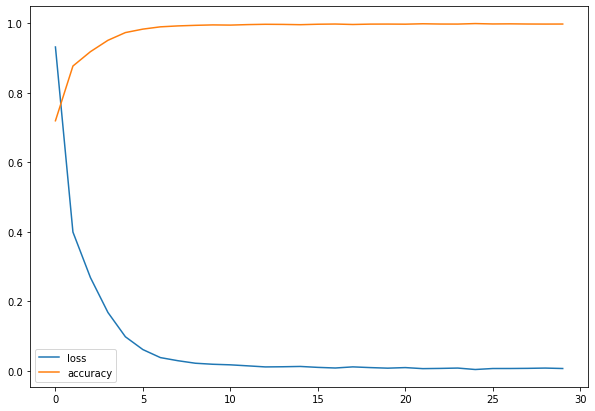

In [ ]:
# Attack model training acc/loss graph
pd.DataFrame(am_history2.history).plot(figsize=(10,7)) 

## Export Best Model
This is where the best AutoKeras-generated model is exported.

In [ ]:
# Export best model (doing early in case of issues)
stolen_model = auto_model.export_model()

In [ ]:
stolen_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 80, 80, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 80, 80, 3)        7         
 n)                                                              
                                                                 
 random_translation (RandomT  (None, 80, 80, 3)        0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 80, 80, 3)         0         
                                                             

## Pred, CM
Attack model's predictions and confusion matrix on its test images

In [ ]:
attack_pred = np.argmax(stolen_model.predict(X_test2), axis=-1)

63/63 [==============================] - 4s 67ms/step


In [ ]:
attack_pred[:10]

array([8, 4, 7, 7, 8, 7, 4, 9, 3, 1])

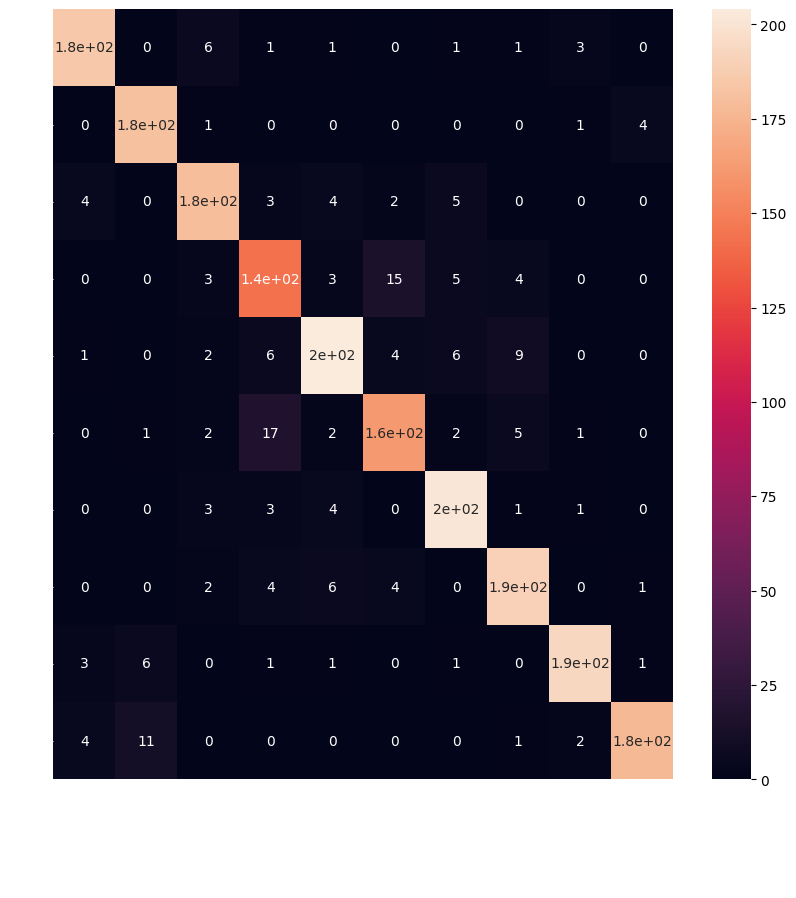

In [ ]:
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 
           'Frog', 'Horse', 'Ship', 'Truck']
# Confusion Matrix on test data
cm = confusion_matrix(y_test2, attack_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True class', color='white')
plt.xlabel('Predicted class', color='white')
plt.tick_params(color='white',labelcolor='white')
plt.show()

# Evaluating Functional Equivalence
I.e., evaluating if we have successfully and effectively stolen the model. <br><br>

To visualize this more closely, we will look at the first 18 images of our subset of data used to train the attack model (X_test). First, we'll look at the actual labels for those images. Next, we'll look at how the victim model predicted labels for those images. Third, we'll look at how the attack model predicted labels for those images. <br><br>

Lastly, to visualize this more accurately, we will then look at the confusion matrices of both the victim and attack model.

## First 18 of X_test -- Actual data
First, we'll look at the first 18 images of X_test (the subset of data the victim model predicted and the attack model was trained on). These initial 18 images will be displayed 9 at a time, and incorporate the correct label above the image.

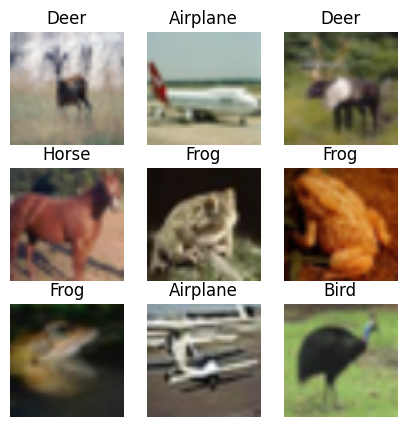

In [ ]:
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 
           'Frog', 'Horse', 'Ship', 'Truck']


# Code below source: https://www.tensorflow.org/tutorials/load_data/images
image_batch, label_batch = next(iter(ds_test))

plt.figure(figsize=(5,5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(classes[label])
  plt.axis("off")

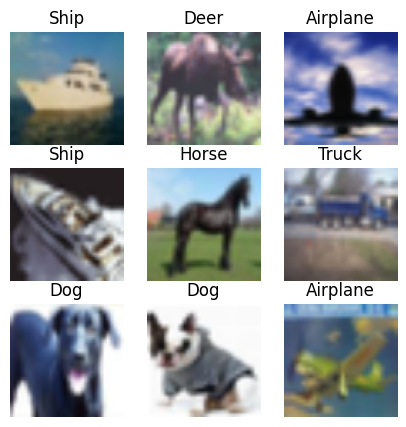

In [ ]:
image_batch, label_batch = next(iter(ds_test))

plt.figure(figsize=(5,5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i+9].numpy().astype("uint8"))
  label = label_batch[i+9]
  plt.title(classes[label])
  plt.axis("off")

## First 18 of X_test -- Victim predictions
Next, we'll use this same strategy, replacing the labels with predictions for the victim model. This will help us visualize accuracy and misclassifications within those first 18 images.

In [ ]:
# Predict on ds_test
y_pred = np.argmax(victim_model.predict(ds_test), axis=-1)
print(y_pred[:9])

625/625 [==============================] - 4s 7ms/step
[4 0 4 7 6 6 6 0 2]


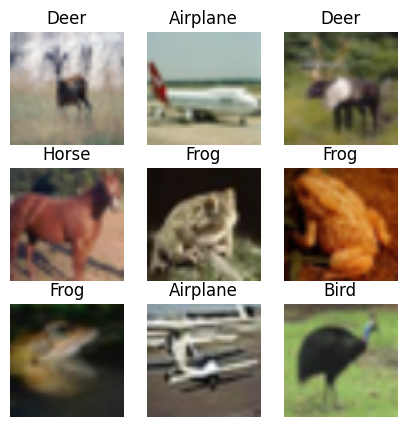

In [ ]:
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 
           'Frog', 'Horse', 'Ship', 'Truck']

image_batch, label_batch = next(iter(ds_test))

plt.figure(figsize=(5,5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = y_pred[i] # using y_pred as labels
  plt.title(classes[label])
  plt.axis("off")

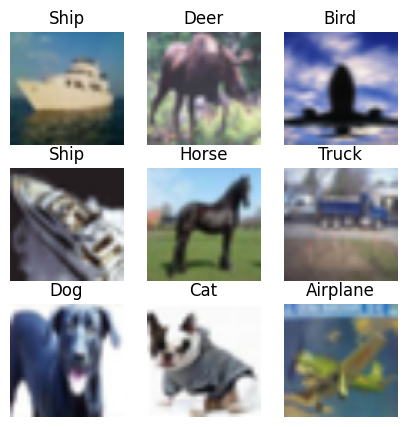

In [ ]:
image_batch, label_batch = next(iter(ds_test))

plt.figure(figsize=(5,5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i+9].numpy().astype("uint8"))
  label = y_pred[i+9] # using y_pred as labels
  plt.title(classes[label])
  plt.axis("off")

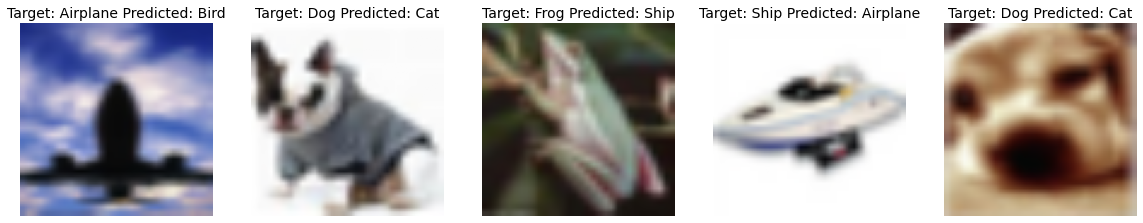

In [ ]:
# Display misclassified images for this experimental model
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 
           'Frog', 'Horse', 'Ship', 'Truck']

misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test, y_pred):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(20,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  plt.imshow(X_test[misclassifiedIndexes[index]].reshape(80,80,3)/255, cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {classes[y_test[misclassifiedIndexes[index]]]} Predicted: {classes[y_pred[misclassifiedIndexes[index]]]}', fontsize=14)

plt.show()

## First 18 of X_test -- Stolen model predictions
Similarily, we'll repeat the previous process for the attack model and its predictions. This will help us visualize accuracy and misclassifications within those first 18 images, as well as get a sense of functionality replication.

In [ ]:
# make predictions on X_test
attack_pred = np.argmax(stolen_model.predict(ds_test), axis=-1)
attack_pred[:9]

625/625 [==============================] - 44s 63ms/step


array([4, 0, 4, 7, 6, 6, 6, 0, 2])

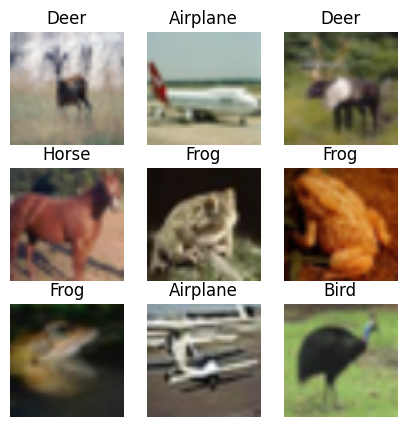

In [ ]:
# Show 
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 
           'Frog', 'Horse', 'Ship', 'Truck']

image_batch, label_batch = next(iter(ds_test))

plt.figure(figsize=(5, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = attack_pred[i] # using attack_pred as labels
  plt.title(classes[label])
  plt.axis("off")

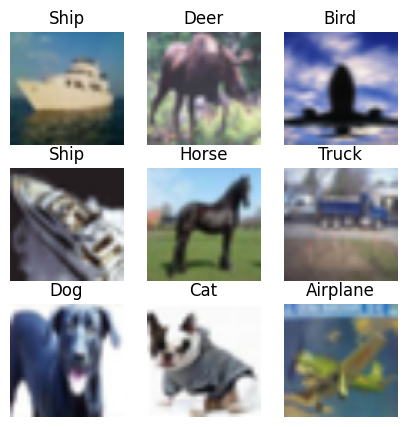

In [ ]:
# Show 
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 
           'Frog', 'Horse', 'Ship', 'Truck']

image_batch, label_batch = next(iter(ds_test))

plt.figure(figsize=(5, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i+9].numpy().astype("uint8"))
  label = attack_pred[i+9] # using attack_pred as labels
  plt.title(classes[label])
  plt.axis("off")

In [ ]:
attack_pred = np.argmax(stolen_model.predict(ds_test), axis=-1)
attack_pred[:10]

625/625 [==============================] - 74s 109ms/step


array([4, 0, 4, 7, 6, 6, 6, 0, 2, 8])

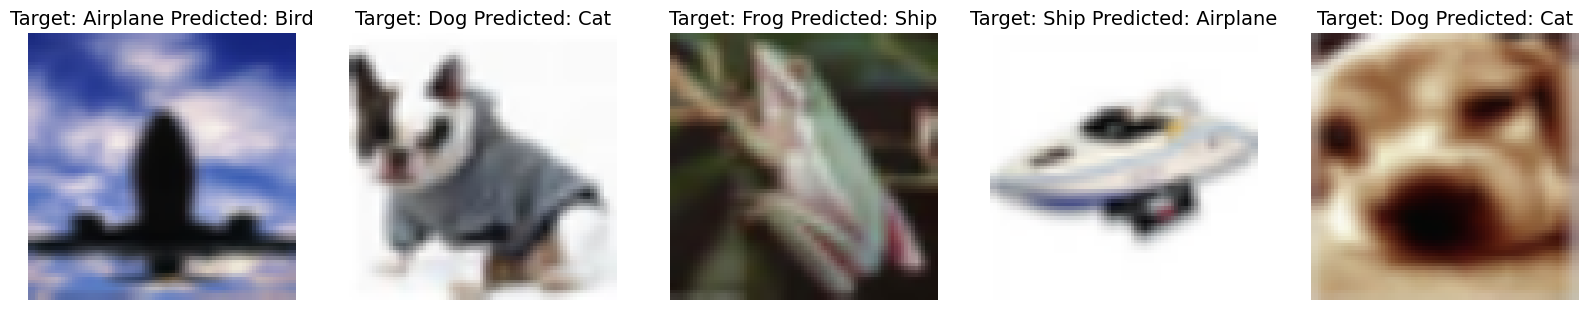

In [ ]:
# Display misclassified images for this experimental model
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 
           'Frog', 'Horse', 'Ship', 'Truck']

misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test, attack_pred):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(20,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  plt.imshow(X_test[misclassifiedIndexes[index]].reshape(80,80,3)/255, cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {classes[y_test[misclassifiedIndexes[index]]]} Predicted: {classes[attack_pred[misclassifiedIndexes[index]]]}', fontsize=14)

plt.show()

## Visualize Functionality Stealing -- Confusion Matrices
Finally, to visualize a more complete picture of this functionality stealing, we will look at the confusion matrices of the victim model and the attack model on the same subset (X_test) of the original data set. If they are similar, the functionality of the victim model has effectively been stolen. The more identical the confusion matrices, the more effective the attack.

In [ ]:
attack_pred2 = np.argmax(stolen_model.predict(ds_test), axis=-1)

625/625 [==============================] - 51s 62ms/step


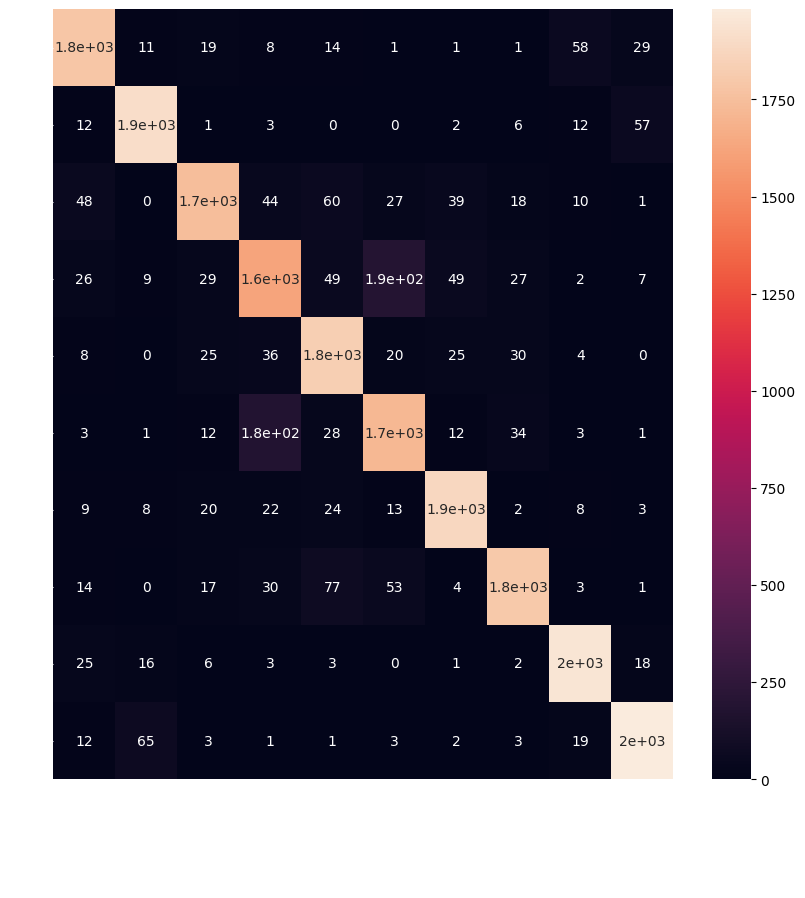

In [ ]:
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 
           'Frog', 'Horse', 'Ship', 'Truck']
# Confusion Matrix for attack model on original (actual) labels
cm = confusion_matrix(y_test, attack_pred2)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True class', color='white')
plt.xlabel('Predicted class', color='white')
plt.tick_params(color='white',labelcolor='white')
plt.show()

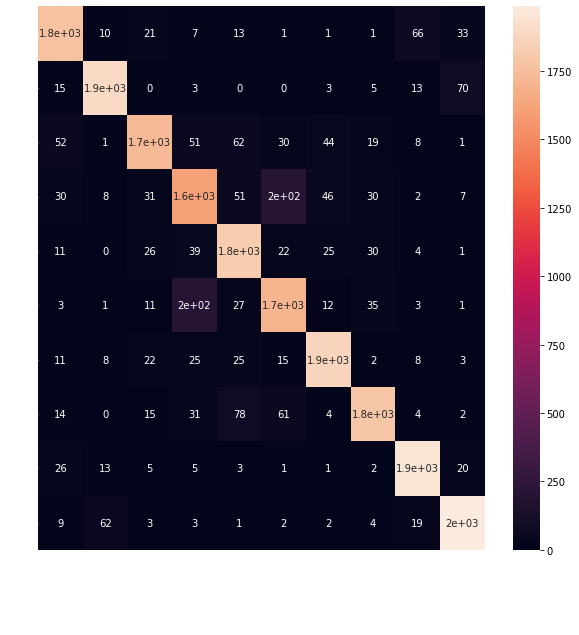

In [ ]:
# Copy of victim model's confusion matrix (on actual labels)